In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set(style="darkgrid", font="serif", context="paper", font_scale=1.5)

import plotly.express as px
import plotly.graph_objects as go

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import libpysal as ps

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = gpd.read_file('GdfSto.shp')
data = data.dropna()
data = data.reset_index(drop=True)
data.head(2)

,FID_grid,Comm_lur,Income,T_Enable,Rd_Pedes,Rd_Ter,T_Hinder,Resi_lur,Health_lur,AreaProx,Other_lur,Edu_lur,LUP_Other,Recre_lur,Rd_Cyc,Public_lur,Rd_Sec,Summer,Winter,Weekend,Rd_Pri,Spring,Dist_cente,trip_count,x,y,geometry
0,9,0.086472,157.0,1.00001,1439.900816,2082.456266,0.00001,0.052529,0.00001,345964.219364,0.697177,0.000010,30.0,0.163862,419.872391,0.00001,0.0,0.0,1.0,0.0,0.0,0.0,5946.427499,7,671201.8641,6.575992e+06,"POLYGON ((671001.864 6575792.310, 671001.864 6..."
1,10,0.000010,177.0,1.00001,1065.726327,2166.682187,0.00001,0.299365,0.00001,660104.976827,0.403699,0.163545,32.0,0.133431,1449.850557,0.00001,0.0,0.0,1.0,0.0,0.0,0.0,5685.068161,34,671601.8641,6.575992e+06,"POLYGON ((671401.864 6575792.310, 671401.864 6..."


In [3]:
data.crs

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden - onshore and offshore.
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

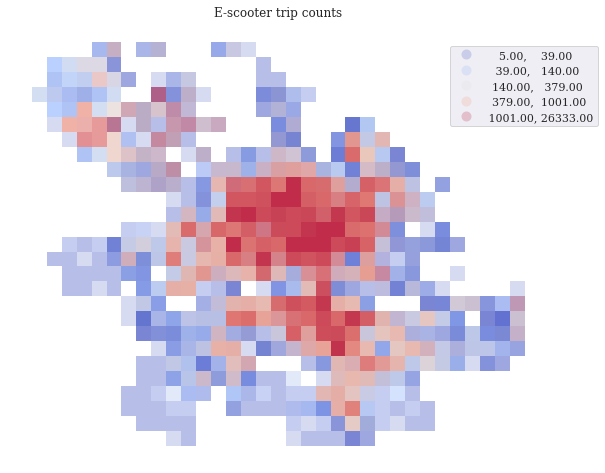

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
data.plot(column='trip_count', cmap='coolwarm', linewidth=0.01, scheme='quantiles', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=ax, alpha=0.2)
ax.set_title('E-scooter trip counts', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
data.columns

Index(['FID_grid', 'Comm_lur', 'Income', 'T_Enable', 'Rd_Pedes', 'Rd_Ter',
       'T_Hinder', 'Resi_lur', 'Health_lur', 'AreaProx', 'Other_lur',
       'Edu_lur', 'LUP_Other', 'Recre_lur', 'Rd_Cyc', 'Public_lur', 'Rd_Sec',
       'Summer', 'Winter', 'Weekend', 'Rd_Pri', 'Spring', 'Dist_cente',
       'trip_count', 'x', 'y', 'geometry'],
      dtype='object')

In [6]:
y = data['trip_count'].values.reshape((-1,1))
X = data[['Comm_lur','Income','T_Enable','Rd_Pedes','Rd_Ter','T_Hinder','Resi_lur','Health_lur','AreaProx','Other_lur',
          'Edu_lur','LUP_Other','Recre_lur','Rd_Cyc','Public_lur','Rd_Sec','Summer','Winter','Weekend','Spring', 
          'Dist_cente']].values

print(X.shape, y.shape)

(2966, 21) (2966, 1)


In [7]:
u = data['x']
v = data['y']
coords = list(zip(u,v))

# GWR model

In [8]:
X = data[['Comm_lur','Income','Rd_Pedes','Resi_lur','AreaProx','Winter','Weekend','Summer','Dist_cente']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape, y.shape)

In [9]:
gwr_selector = Sel_BW(coords, y, X_scaled)
gwr_bw = gwr_selector.search()
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 155.0


In [10]:
gwr_results = GWR(coords, y, X_scaled, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2966
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       4503940154.539
Log-likelihood:                                                  -25316.480
AIC:                                                              50652.960
AICc:                                                             50655.049
BIC:                                                           4503916521.410
R2:                                                                   0.439
Adj. R2:                                                              0.437

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- --

In [11]:
# the (average) R2, AIC, and AICc
print('Mean R2 =', gwr_results.R2)
print('AIC =', gwr_results.aic)
print('AICc =', gwr_results.aicc)

Mean R2 = 0.8882538515841125
AIC = 46659.26020778302
AICc = 46788.95041335313


In [12]:
data['gwr_R2'] = gwr_results.localR2

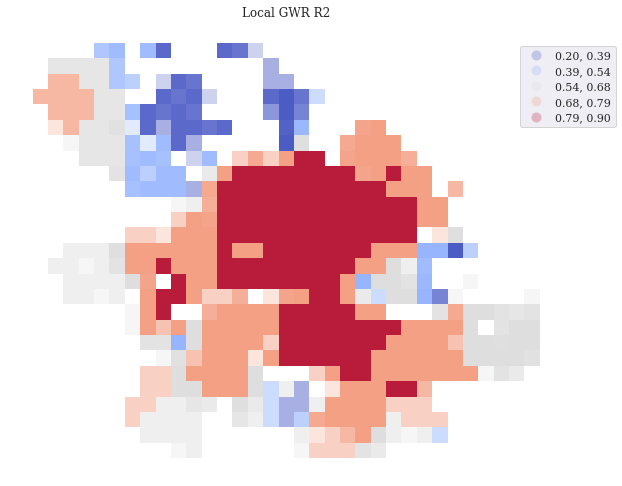

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(column='gwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'naturalbreaks', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.25)
ax.set_title('Local GWR R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [14]:
features = ['Comm_lur','Income','Rd_Pedes','Resi_lur','AreaProx','Winter','Weekend','Summer','Dist_cente']

for i, feature in enumerate(features):
    data[f'gwr_{feature}'] = gwr_results.params[:, i]
    
data.head(2)

,FID_grid,Comm_lur,Income,T_Enable,Rd_Pedes,Rd_Ter,T_Hinder,Resi_lur,Health_lur,AreaProx,Other_lur,Edu_lur,LUP_Other,Recre_lur,Rd_Cyc,Public_lur,Rd_Sec,Summer,Winter,Weekend,Rd_Pri,Spring,Dist_cente,trip_count,x,y,geometry,gwr_R2,gwr_Comm_lur,gwr_Income,gwr_Rd_Pedes,gwr_Resi_lur,gwr_AreaProx,gwr_Winter,gwr_Weekend,gwr_Summer,gwr_Dist_cente
0,9,0.086472,157.0,1.00001,1439.900816,2082.456266,0.00001,0.052529,0.00001,345964.219364,0.697177,0.000010,30.0,0.163862,419.872391,0.00001,0.0,0.0,1.0,0.0,0.0,0.0,5946.427499,7,671201.8641,6.575992e+06,"POLYGON ((671001.864 6575792.310, 671001.864 6...",0.619006,265.658675,-33.720020,183.867253,17.785247,-21.205079,5.829893,-1.684974,-34.822425,83.280553
1,10,0.000010,177.0,1.00001,1065.726327,2166.682187,0.00001,0.299365,0.00001,660104.976827,0.403699,0.163545,32.0,0.133431,1449.850557,0.00001,0.0,0.0,1.0,0.0,0.0,0.0,5685.068161,34,671601.8641,6.575992e+06,"POLYGON ((671401.864 6575792.310, 671401.864 6...",0.592919,283.699971,-39.948659,207.533897,23.221847,-21.786240,19.966222,0.000293,-38.892956,71.266199


# Filter/correct t-stats

In [15]:
# Filter t-values: standard alpha = 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)
# Filter t-values: corrected alpha due to multiple testing
gwr_filtered_tc = gwr_results.filter_tvals()
data.columns

Index(['FID_grid', 'Comm_lur', 'Income', 'T_Enable', 'Rd_Pedes', 'Rd_Ter',
       'T_Hinder', 'Resi_lur', 'Health_lur', 'AreaProx', 'Other_lur',
       'Edu_lur', 'LUP_Other', 'Recre_lur', 'Rd_Cyc', 'Public_lur', 'Rd_Sec',
       'Summer', 'Winter', 'Weekend', 'Rd_Pri', 'Spring', 'Dist_cente',
       'trip_count', 'x', 'y', 'geometry', 'gwr_R2', 'gwr_Comm_lur',
       'gwr_Income', 'gwr_Rd_Pedes', 'gwr_Resi_lur', 'gwr_AreaProx',
       'gwr_Winter', 'gwr_Weekend', 'gwr_Summer', 'gwr_Dist_cente'],
      dtype='object')

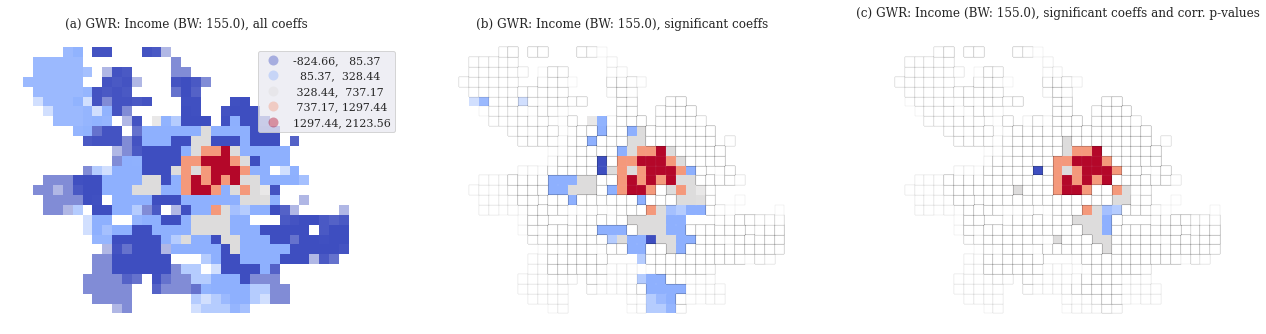

In [16]:
# Map coefficients- Income
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

data.plot(column='gwr_Income', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)}, ax=axes[0], alpha=0.4)

data.plot(column='gwr_Income', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)}, ax=axes[1], alpha=0.4)
data[gwr_filtered_t[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

data.plot(column='gwr_Income', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)}, ax=axes[2], alpha=0.4)
data[gwr_filtered_tc[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Income (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Income (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[2].set_title('(c) GWR: Income (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
plt.show()

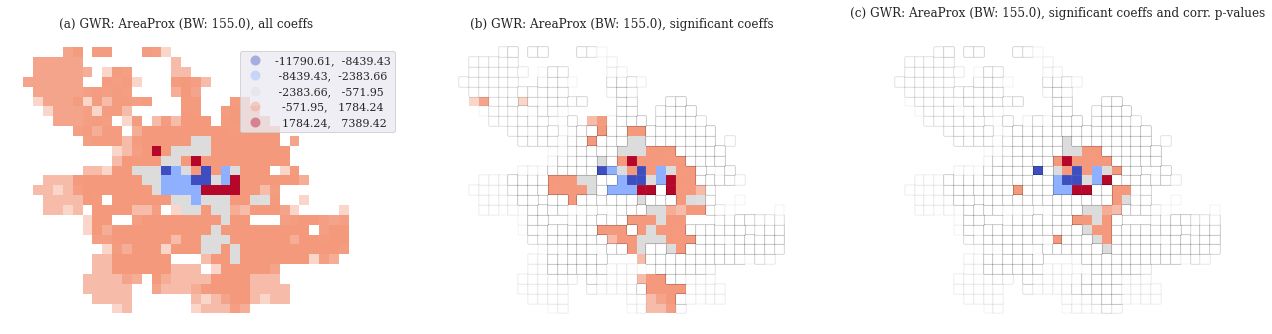

In [17]:
# Map coefficients for 'AreaProx'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

data.plot(column='gwr_AreaProx', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[0], alpha=0.4)

data.plot(column='gwr_AreaProx', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[1], alpha=0.4)
data[gwr_filtered_t[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

data.plot(column='gwr_AreaProx', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[2], alpha=0.4)
data[gwr_filtered_tc[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: AreaProx (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: AreaProx (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[2].set_title('(c) GWR: AreaProx (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
plt.show()

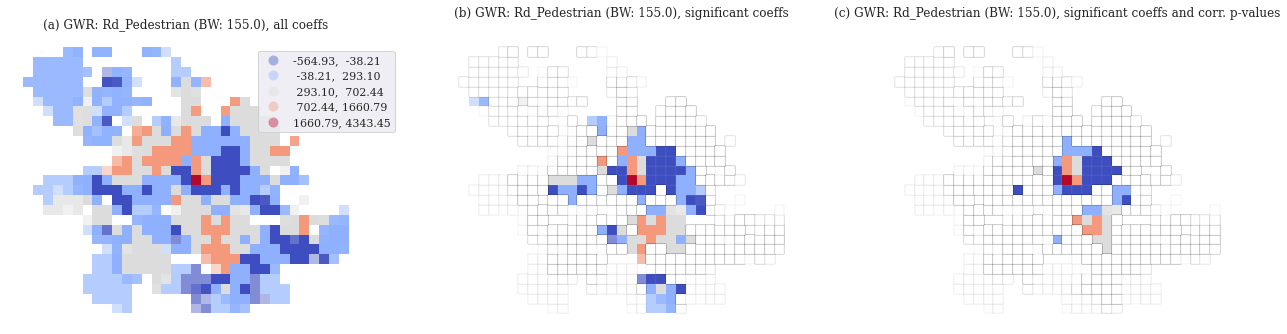

In [18]:
# Map coefficients for 'Rd_Pedes'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

data.plot(column='gwr_Rd_Pedes', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[0], alpha=0.4)

data.plot(column='gwr_Rd_Pedes', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[1], alpha=0.4)
data[gwr_filtered_t[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

data.plot(column='gwr_Rd_Pedes', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[2], alpha=0.4)
data[gwr_filtered_tc[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Rd_Pedestrian (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Rd_Pedestrian (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[2].set_title('(c) GWR: Rd_Pedestrian (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
plt.show()

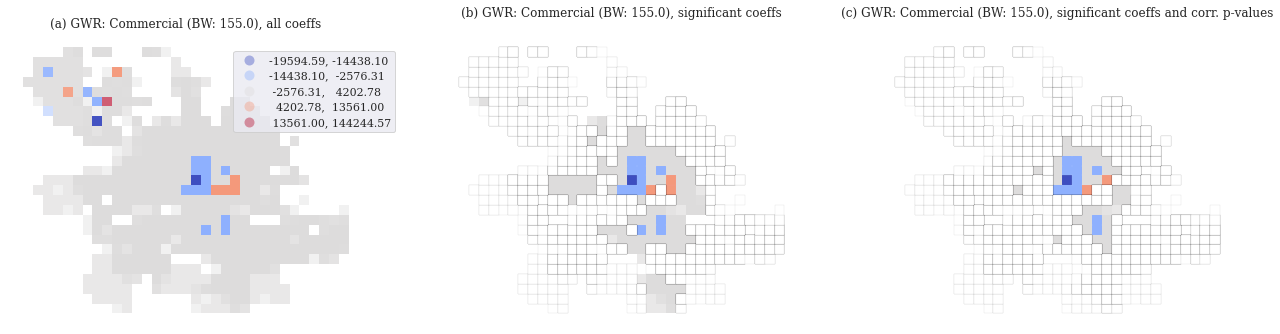

In [19]:
# Map coefficients for 'Comm_lur'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

data.plot(column='gwr_Comm_lur', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[0], alpha=0.4)

data.plot(column='gwr_Comm_lur', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[1], alpha=0.4)
data[gwr_filtered_t[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

data.plot(column='gwr_Comm_lur', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[2], alpha=0.4)
data[gwr_filtered_tc[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Commercial (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Commercial (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[2].set_title('(c) GWR: Commercial (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
plt.show()

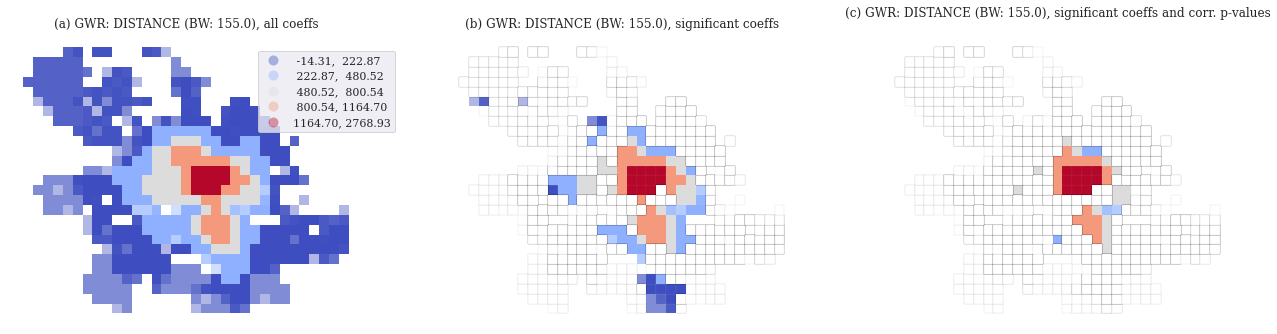

In [20]:
# Map coefficients for 'DISTANCE'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

data.plot(column='gwr_Dist_cente', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[0], alpha=0.4)

data.plot(column='gwr_Dist_cente', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[1], alpha=0.4)
data[gwr_filtered_t[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

data.plot(column='gwr_Dist_cente', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[2], alpha=0.4)
data[gwr_filtered_tc[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: DISTANCE (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: DISTANCE (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[2].set_title('(c) GWR: DISTANCE (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
plt.show()

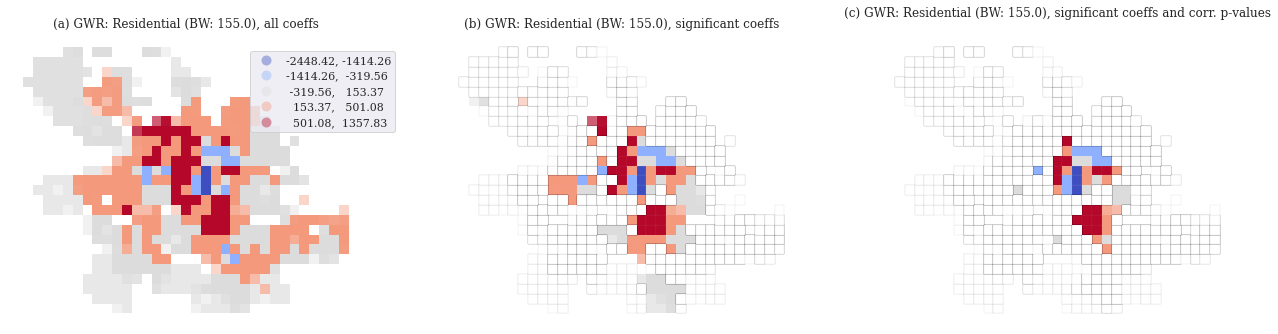

In [21]:
# Map coefficients for 'Residential'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

data.plot(column='gwr_Resi_lur', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[0], alpha=0.4)

data.plot(column='gwr_Resi_lur', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[1], alpha=0.4)
data[gwr_filtered_t[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

data.plot(column='gwr_Resi_lur', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[2], alpha=0.4)
data[gwr_filtered_tc[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Residential (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Residential (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[2].set_title('(c) GWR: Residential (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
plt.show()

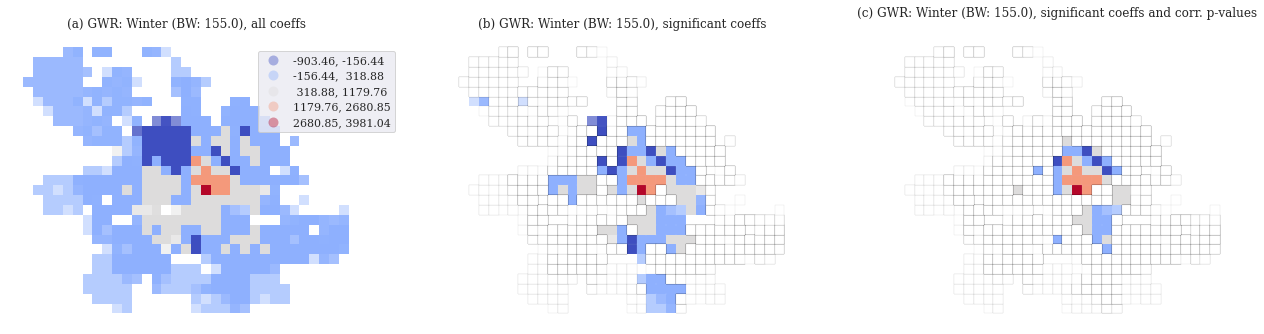

In [22]:
# Map coefficients for 'Winter'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

data.plot(column='gwr_Winter', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[0], alpha=0.4)

data.plot(column='gwr_Winter', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[1], alpha=0.4)
data[gwr_filtered_t[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

data.plot(column='gwr_Winter', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[2], alpha=0.4)
data[gwr_filtered_tc[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Winter (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Winter (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[2].set_title('(c) GWR: Winter (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
plt.show()

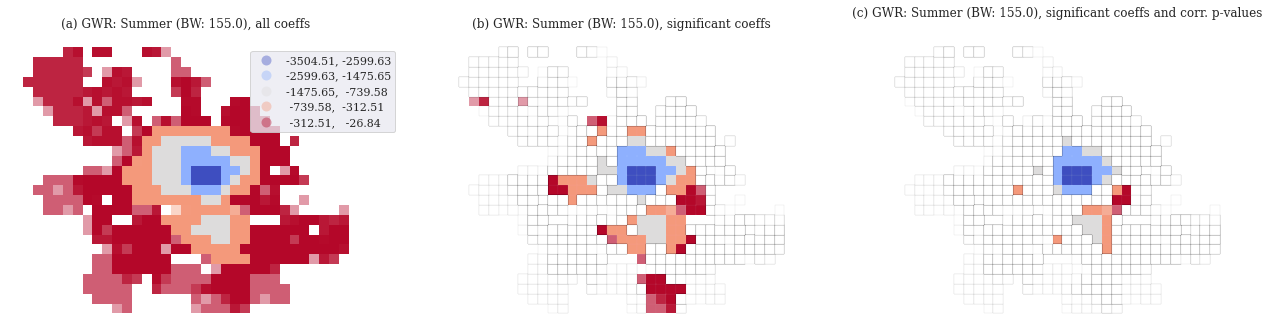

In [23]:
# Map coefficients for 'Summer'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

data.plot(column='gwr_Summer', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[0], alpha=0.4)

data.plot(column='gwr_Summer', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[1], alpha=0.4)
data[gwr_filtered_t[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

data.plot(column='gwr_Summer', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[2], alpha=0.4)
data[gwr_filtered_tc[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Summer (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Summer (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[2].set_title('(c) GWR: Summer (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
plt.show()

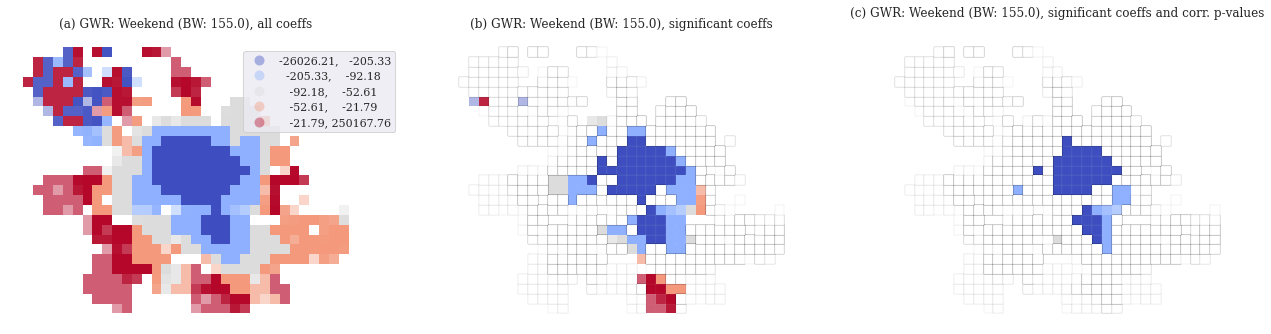

In [24]:
# Map coefficients for 'Weekend'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

data.plot(column='gwr_Weekend', cmap='coolwarm', linewidth=0.01, scheme='quantiles', k=5, legend=True, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[0], alpha=0.4)

data.plot(column='gwr_Weekend', cmap='coolwarm', linewidth=0.05, scheme='quantiles', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[1], alpha=0.4)
data[gwr_filtered_t[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

data.plot(column='gwr_Weekend', cmap='coolwarm', linewidth=0.05, scheme='quantiles', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[2], alpha=0.4)
data[gwr_filtered_tc[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Weekend (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Weekend (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[2].set_title('(c) GWR: Weekend (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
plt.show()

# Test spatial stationarity

In [25]:
# Monte Carlo test of spatial variability: 500 iterations 
gwr_p_values_stationarity = gwr_results.spatial_variability(gwr_selector, 500)

In [26]:
gwr_p_values_stationarity
#  first p-value is for the intercept

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Test local multicollinearity

In [27]:
LCC, VIF, CN, VDP = gwr_results.local_collinearity()
pd.DataFrame(VIF)

,0,1,2,3,4,5,6,7,8
0,1.779384,1.210684,1.350500,1.343704,1.200318,2.412837,1.005334,1.409530,2.487279
1,1.641411,1.138607,1.333044,1.297172,1.126329,2.347920,1.005635,1.438441,2.241845
2,1.641411,1.138607,1.333044,1.297172,1.126329,2.347920,1.005635,1.438441,2.241845
3,1.894295,1.673972,1.945063,1.544202,1.961397,1.776825,1.006199,1.521594,2.431623
4,1.950585,1.416057,1.798259,1.715459,2.161371,1.589210,1.006019,1.383993,2.959807
...,...,...,...,...,...,...,...,...,...
2961,1.834801,2.137547,1.220005,2.249212,1.259313,1.567075,1.011275,1.133429,2.269462
2962,1.834801,2.137547,1.220005,2.249212,1.259313,1.567075,1.011275,1.133429,2.269462
2963,1.834801,2.137547,1.220005,2.249212,1.259313,1.567075,1.011275,1.133429,2.269462
2964,1.834801,2.137547,1.220005,2.249212,1.259313,1.567075,1.011275,1.133429,2.269462


In [28]:
pd.DataFrame(VIF).describe().round(2)

,0,1,2,3,4,5,6,7,8
count,2855.00,2855.00,2855.00,2855.00,2855.00,2855.00,2855.00,2855.00,2855.00
mean,2.90,3.71,3.24,2.45,3.19,1.20,1.00,1.15,3.33
std,2.72,3.47,2.79,1.73,2.34,0.20,0.01,0.07,3.12
min,1.06,1.05,1.03,1.06,1.09,1.00,1.00,1.00,1.03
25%,1.65,1.86,1.66,1.51,1.72,1.13,1.00,1.12,1.81
50%,2.22,2.63,2.30,1.94,2.46,1.13,1.00,1.13,2.44
75%,3.17,4.28,3.67,2.67,3.81,1.17,1.00,1.16,3.72
max,33.55,27.42,22.24,16.91,19.37,2.49,1.07,1.79,36.76


In [29]:
pd.DataFrame(CN)

,0
0,17.543338
1,14.625470
2,14.625470
3,14.928074
4,15.072851
...,...
2961,29.522722
2962,29.522722
2963,29.522722
2964,29.522722


In [30]:
data['gwr_CN'] = CN

In [31]:
df = pd.DataFrame(VIF)
df.columns=['Comm_lur','Income','Rd_Pedes','Resi_lur','AreaProx','Winter','Weekend','Summer','Dist_cente']
df.head()

,Comm_lur,Income,Rd_Pedes,Resi_lur,AreaProx,Winter,Weekend,Summer,Dist_cente
0,1.779384,1.210684,1.350500,1.343704,1.200318,2.412837,1.005334,1.409530,2.487279
1,1.641411,1.138607,1.333044,1.297172,1.126329,2.347920,1.005635,1.438441,2.241845
2,1.641411,1.138607,1.333044,1.297172,1.126329,2.347920,1.005635,1.438441,2.241845
3,1.894295,1.673972,1.945063,1.544202,1.961397,1.776825,1.006199,1.521594,2.431623
4,1.950585,1.416057,1.798259,1.715459,2.161371,1.589210,1.006019,1.383993,2.959807


In [33]:
df['Avg']=df.mean(axis=1)
df = df.sort_values(by = 'Avg')
df['Avg'].max()

10.77363596349347

In [34]:
data['vif_Rd_Ped']=df['Rd_Pedes']
data['vif_Summer']=df['Summer']
data['vif_Comm']=df['Comm_lur']
data['vif_Income']=df['Income']
data['vif_Dist']=df['Dist_cente']
data['vif_AreaProx']=df['AreaProx']
data['vif_Winter']=df['Winter']
data['vif_Resi']=df['Resi_lur']
data['vif_Weekend']=df['Weekend']

data.head(2)

,FID_grid,Comm_lur,Income,T_Enable,Rd_Pedes,Rd_Ter,T_Hinder,Resi_lur,Health_lur,AreaProx,Other_lur,Edu_lur,LUP_Other,Recre_lur,Rd_Cyc,Public_lur,Rd_Sec,Summer,Winter,Weekend,Rd_Pri,Spring,Dist_cente,trip_count,x,y,geometry,gwr_R2,gwr_Comm_lur,gwr_Income,gwr_Rd_Pedes,gwr_Resi_lur,gwr_AreaProx,gwr_Winter,gwr_Weekend,gwr_Summer,gwr_Dist_cente,gwr_CN,vif_Rd_Ped,vif_Summer,vif_Comm,vif_Income,vif_Dist,vif_AreaProx,vif_Winter,vif_Resi,vif_Weekend
0,9,0.086472,157.0,1.00001,1439.900816,2082.456266,0.00001,0.052529,0.00001,345964.219364,0.697177,0.000010,30.0,0.163862,419.872391,0.00001,0.0,0.0,1.0,0.0,0.0,0.0,5946.427499,7,671201.8641,6.575992e+06,"POLYGON ((671001.864 6575792.310, 671001.864 6...",0.619006,265.658675,-33.720020,183.867253,17.785247,-21.205079,5.829893,-1.684974,-34.822425,83.280553,17.543338,1.350500,1.409530,1.779384,1.210684,2.487279,1.200318,2.412837,1.343704,1.005334
1,10,0.000010,177.0,1.00001,1065.726327,2166.682187,0.00001,0.299365,0.00001,660104.976827,0.403699,0.163545,32.0,0.133431,1449.850557,0.00001,0.0,0.0,1.0,0.0,0.0,0.0,5685.068161,34,671601.8641,6.575992e+06,"POLYGON ((671401.864 6575792.310, 671401.864 6...",0.592919,283.699971,-39.948659,207.533897,23.221847,-21.786240,19.966222,0.000293,-38.892956,71.266199,14.625470,1.333044,1.438441,1.641411,1.138607,2.241845,1.126329,2.347920,1.297172,1.005635


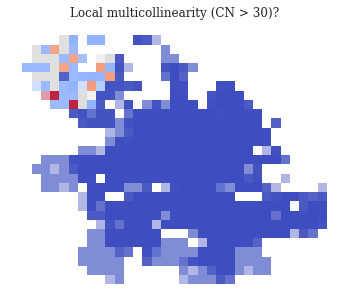

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='gwr_CN', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('Local multicollinearity (CN > 30)?', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

# VIF

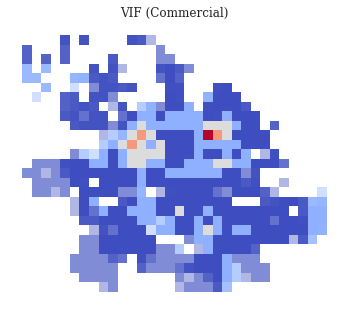

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='vif_Comm', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('VIF (Commercial)', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

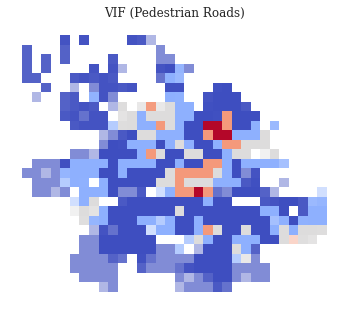

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='vif_Rd_Ped', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('VIF (Pedestrian Roads)', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

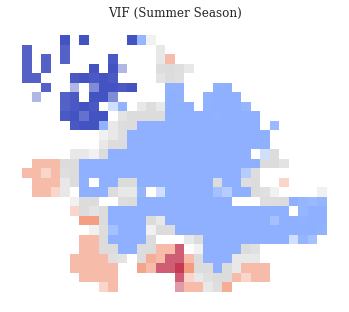

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='vif_Summer', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('VIF (Summer Season)', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

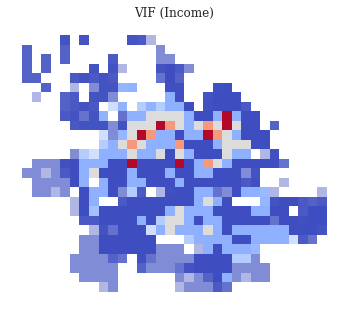

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='vif_Income', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('VIF (Income)', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

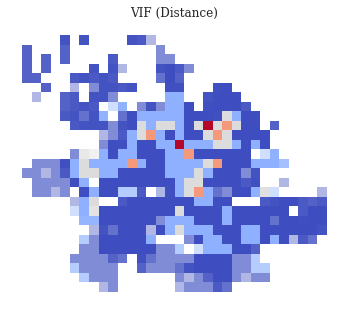

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='vif_Dist', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('VIF (Distance)', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

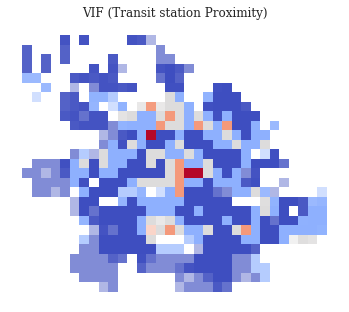

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='vif_AreaProx', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('VIF (Transit station Proximity)', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

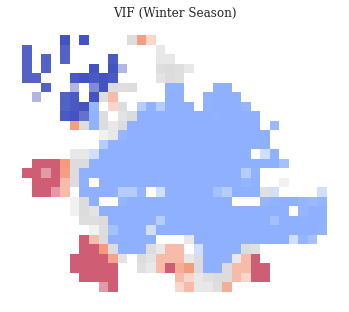

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='vif_Winter', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('VIF (Winter Season)', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

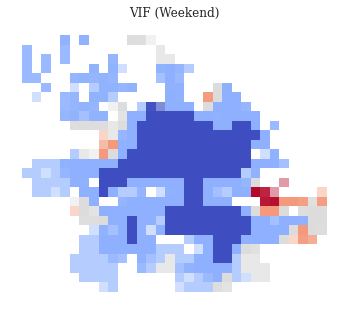

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='vif_Weekend', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('VIF (Weekend)', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

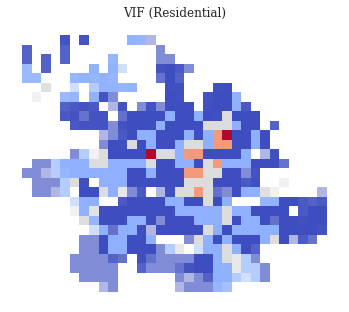

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))
data.plot(column='vif_Resi', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=False, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax, alpha=0.4)
ax.set_title('VIF (Residential)', fontsize=12)
ax.axis("off")
# plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [45]:
output_file = 'GWR_values.shp'
data.to_file(output_file)